<a href="https://colab.research.google.com/github/dipansh-girdhar/Projects-Assignments---Data-Science-Analytics/blob/master/Text%20Clustering/Text_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [0]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:
from google.colab import files

In [0]:
data=files.upload()

Saving UnFound_clustering_assignment - UnFound_clustering_assignment.csv to UnFound_clustering_assignment - UnFound_clustering_assignment.csv


In [0]:
data=pd.read_csv("UnFound_clustering_assignment - UnFound_clustering_assignment.csv")

In [0]:
data=data.loc[:,['SENTENCES']]

In [0]:
data.head()

,SENTENCES
0,"Moeller's student-run newspaper, The Crusader,..."
1,"In 2008, The Crusader won First Place, the sec..."
2,The Squire is a student literary journal that ...
3,Paul Keels - play-by-play announcer for Ohio S...
4,Joe Uecker - Ohio State Senator (R-66) .


In [0]:
data.shape

(46117, 1)

In [0]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


In [0]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

In [0]:
reindexed_data = data['SENTENCES']
reindexed_data.values

array(["Moeller's student-run newspaper, The Crusader, is consistently recognized as being one of the top in the region.",
       'In 2008, The Crusader won First Place, the second-highest honor a high school newspaper can receive from the American Scholastic Press Association [REF].',
       'The Squire is a student literary journal that features stories, poems, and essays written by Moeller students.',
       ...,
       'The Vancouver Art Gallery is housed downtown in the neoclassical former courthouse built in 1906.',
       "A prominent addition to the city's landscape is the giant tent-frame Canada Place (designed by Zeidler Roberts Partnership Partnership, MCMP & DA Architects), the former Canada Pavilion from the 1986 World Exposition, which includes part of the Convention Centre, the Pan-Pacific Hotel, and a cruise ship terminal.",
       "A collection of Edwardian buildings in the city's old downtown core were, in their day, the tallest commercial buildings in the British Emp

In [0]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,  
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

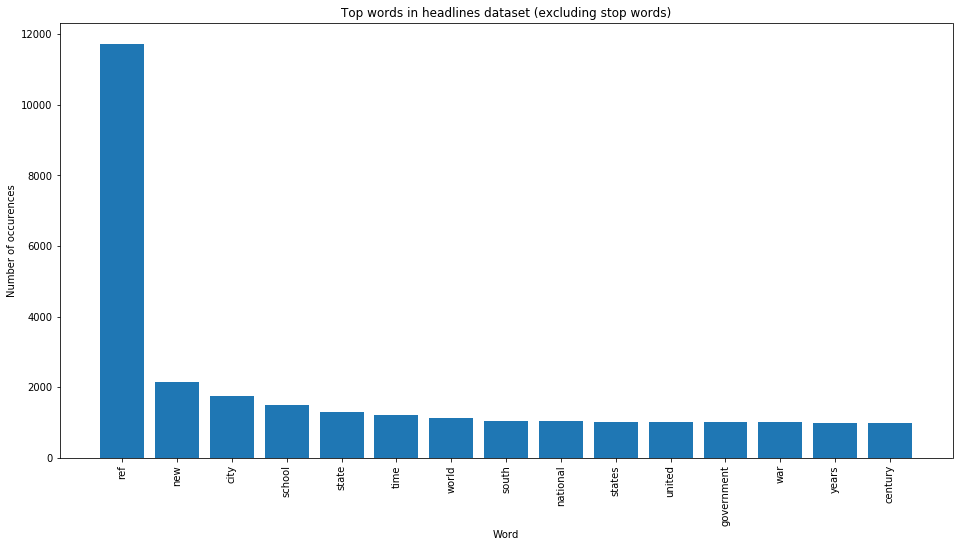

In [0]:
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [0]:
tagged_headlines = [TextBlob(reindexed_data[i]).pos_tags for i in range(reindexed_data.shape[0])]

In [0]:
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per headline: ', np.mean(word_counts))

Total number of words:  1020452
Mean number of words per headline:  22.127458420972744


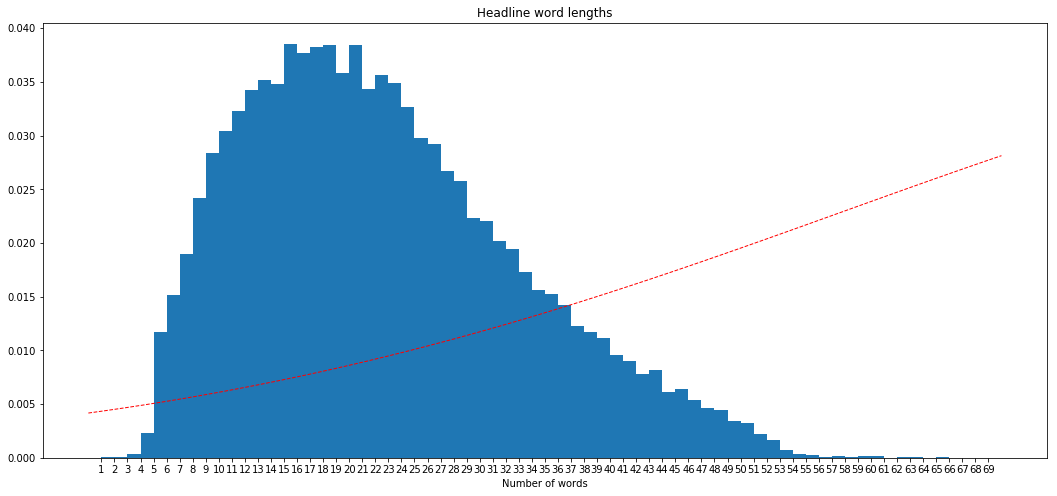

In [0]:
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,70), density=True);
ax.plot(np.linspace(0,70,50), y, 'r--', linewidth=1);
ax.set_title('Headline word lengths');
ax.set_xticks(range(1,70));
ax.set_xlabel('Number of words');
plt.show()

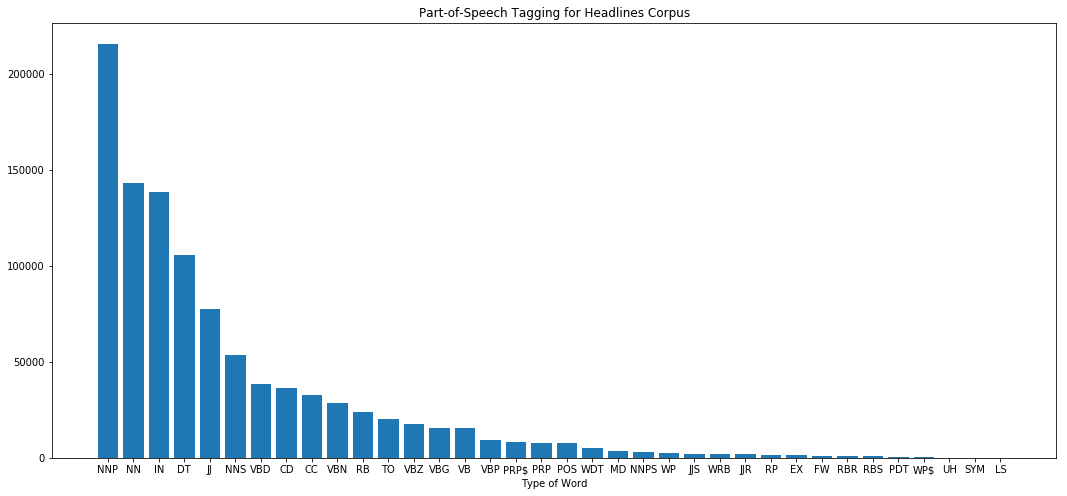

In [0]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tagging for Headlines Corpus');
ax.set_xlabel('Type of Word');

In [0]:
# small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
# small_text_sample = reindexed_data.sample(n=10000, random_state=0).values

# print('Headline before vectorization: {}'.format(small_text_sample[123]))

# small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

# print('Headline after vectorization: \n{}'.format(small_document_term_matrix[123]))

In [0]:
big_sample_size = 46117
n_topics=8
big_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
big_text_sample = reindexed_data.values
big_document_term_matrix = big_count_vectorizer.fit_transform(big_text_sample)


In [0]:
big_text_sample

array(["Moeller's student-run newspaper, The Crusader, is consistently recognized as being one of the top in the region.",
       'In 2008, The Crusader won First Place, the second-highest honor a high school newspaper can receive from the American Scholastic Press Association [REF].',
       'The Squire is a student literary journal that features stories, poems, and essays written by Moeller students.',
       ...,
       'The Vancouver Art Gallery is housed downtown in the neoclassical former courthouse built in 1906.',
       "A prominent addition to the city's landscape is the giant tent-frame Canada Place (designed by Zeidler Roberts Partnership Partnership, MCMP & DA Architects), the former Canada Pavilion from the 1986 World Exposition, which includes part of the Convention Centre, the Pan-Pacific Hotel, and a cruise ship terminal.",
       "A collection of Edwardian buildings in the city's old downtown core were, in their day, the tallest commercial buildings in the British Emp

In [0]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(big_document_term_matrix)

In [0]:
lda_topic_matrix

array([[0.01388889, 0.01388889, 0.12493614, ..., 0.01388889, 0.01388889,
        0.01388889],
       [0.00735344, 0.07021014, 0.06671795, ..., 0.00735396, 0.00735454,
        0.00735435],
       [0.01041667, 0.01041667, 0.01041667, ..., 0.01041667, 0.01041667,
        0.67707206],
       ...,
       [0.11250224, 0.0125    , 0.11249889, ..., 0.39479871, 0.1302035 ,
        0.0125    ],
       [0.10080378, 0.11907574, 0.0364174 , ..., 0.12894519, 0.12087707,
        0.08003317],
       [0.00893174, 0.17813106, 0.00892888, ..., 0.29463229, 0.22393659,
        0.08035516]])

In [0]:
final_labels=[]
for i in lda_topic_matrix:
  final_labels.append(np.argmax(i))

In [0]:
data["topic_classified"]=final_labels

In [0]:
data.head()

,SENTENCES,topic_classified
0,"Moeller's student-run newspaper, The Crusader,...",3
1,"In 2008, The Crusader won First Place, the sec...",4
2,The Squire is a student literary journal that ...,7
3,Paul Keels - play-by-play announcer for Ohio S...,0
4,Joe Uecker - Ohio State Senator (R-66) .,0


In [0]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [0]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [0]:
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words


In [0]:
top_n_words_lda = get_top_n_words(10, lda_keys, big_document_term_matrix, big_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  ref service university state west new department river station minister
Topic 2:  ref new city royal united air force states police president
Topic 3:  ref season film north home mp new music dracula city
Topic 4:  ref school city area state new district national high church
Topic 5:  ref american people known used series act years new population
Topic 6:  ref used years use including general life early new number
Topic 7:  ref century time united states john early 000 year british
Topic 8:  ref war government world south new party civil international state


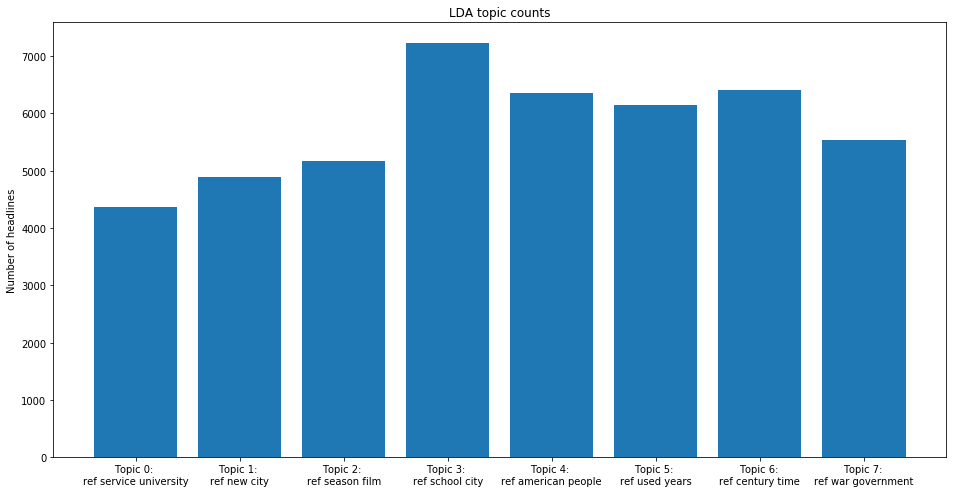

In [0]:
top_3_words = get_top_n_words(3, lda_keys, big_document_term_matrix, big_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');

In [0]:
data.to_csv("unfound_data_classified.csv")

In [0]:
files.download("unfound_data_classified.csv")